## AI/ML Applications in Civil Engineering  
## Problem Set 04 — Beam Deflection Prediction using ANN  

**Harshita:**  
**24CE10087:**  



In [26]:
#data Generation
import numpy as np
import pandas as pd

# Constant Flexural Rigidity
EI = 200000 

def generate_beam_data(n_samples=5000):
    data = []
    for _ in range(n_samples):
        ptype = np.random.randint(1, 9) # 8 Types of problems
        L = np.random.uniform(3.0, 15.0)
        w = np.random.uniform(0.0, 50.0)
        P = np.random.uniform(0.0, 100.0)
        a = np.random.uniform(0.05 * L, 0.95 * L)
        b = L - a
        
        # Initialize outputs
        RL = RR = ML = MR = Mspan = Delta = 0

        # Logic for all 8 problems based on your PDF formulas
        if ptype == 1: # Cantilever, Point Load
            RL = P; ML = P*a; Delta = (P * a**2 * (3*L - a)) / (6 * EI)
        elif ptype == 2: # Cantilever, UDL
            RL = w*L; ML = 0.5*w*L**2; Delta = (w * L**4) / (8 * EI)
        elif ptype == 3: # Simply Supported, Point Load
            RL = P*b/L; RR = P*a/L; Mspan = (P*a*b)/L; Delta = (P*L**3)/(48*EI)
        elif ptype == 4: # Simply Supported, UDL
            RL = RR = w*L/2; Mspan = w*L**2/8; Delta = (5*w*L**4)/(384*EI)
        elif ptype == 5: # Propped Cantilever, Point Load
            RL = P*(2*L**3 - 3*L*a**2 + a**3)/(2*L**3)
            RR = P*a**2*(3*L - a)/(2*L**3)
            ML = P*a*(2*L - a)*(L - a)/(2*L**2)
            Delta = (P*a**2*(L-a)/(6*EI*(3*L-a))) * np.sqrt(3*L**2 - 4*L*a + a**2)
        elif ptype == 6: # Propped Cantilever, UDL
            RL = 5*w*L/8; RR = 3*w*L/8; ML = w*L**2/8; Delta = 0.00542*(w*L**4)/EI
        elif ptype == 7: # Fixed End, Point Load
            RL = P*b**2*(3*a+b)/L**3; RR = P*a**2*(a+3*b)/L**3
            ML = P*a*b**2/L**2; MR = P*a**2*b/L**2; Delta = (P*L**3)/(192*EI)
        elif ptype == 8: # Fixed End, UDL
            RL = RR = w*L/2; ML = MR = w*L**2/12; Mspan = w*L**2/24; Delta = (w*L**4)/(384*EI)

        data.append([ptype, L, w, P, a, RL, RR, ML, MR, Mspan, Delta])

    columns = ['Type', 'L', 'w', 'P', 'a', 'RL', 'RR', 'ML', 'MR', 'Mspan', 'DeltaMax']
    return pd.DataFrame(data, columns=columns)

df = generate_beam_data()
df.to_csv('beam_dataset.csv', index=False)
print("Dataset generated with 5000 samples. Validating ranges:")
print(df[['L', 'w', 'P']].describe().loc[['min', 'max']])

Dataset generated with 5000 samples. Validating ranges:
             L          w          P
min   3.004139   0.004968   0.048631
max  14.984705  49.998101  99.985563


In [27]:
#Creating an ANN
class NumpyANN:
    def __init__(self, input_size, hidden_size, output_size):
        # Initialize weights with small random numbers
        self.W1 = np.random.randn(input_size, hidden_size) * 0.01
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * 0.01
        self.b2 = np.zeros((1, output_size))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, X):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.sigmoid(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        return self.z2 # Linear output for regression

    def train(self, X, y, learning_rate=0.01, epochs=1000):
        for epoch in range(epochs):
            # Forward Pass
            output = self.forward(X)
            
            # Calculate Error (MSE)
            error = output - y
            
            # Backpropagation (The Math)
            d_W2 = np.dot(self.a1.T, error)
            d_b2 = np.sum(error, axis=0, keepdims=True)
            
            d_a1 = np.dot(error, self.W2.T)
            d_z1 = d_a1 * (self.a1 * (1 - self.a1)) # Sigmoid derivative
            
            d_W1 = np.dot(X.T, d_z1)
            d_b1 = np.sum(d_z1, axis=0, keepdims=True)
            
            # Update Weights
            self.W2 -= learning_rate * d_W2 / X.shape[0]
            self.b2 -= learning_rate * d_b2 / X.shape[0]
            self.W1 -= learning_rate * d_W1 / X.shape[0]
            self.b1 -= learning_rate * d_b1 / X.shape[0]
            
            if epoch % 100 == 0:
                loss = np.mean(np.square(error))
                print(f"Epoch {epoch}, Loss: {loss:.6f}")

# Data Normalization (Essential for NumPy ANN)
X_raw = df[['Type', 'L', 'w', 'P', 'a']].values
y_raw = df[['RL', 'RR', 'ML', 'MR', 'Mspan', 'DeltaMax']].values

X_mean, X_std = X_raw.mean(axis=0), X_raw.std(axis=0)
y_mean, y_std = y_raw.mean(axis=0), y_raw.std(axis=0)

X_scaled = (X_raw - X_mean) / X_std
y_scaled = (y_raw - y_mean) / y_std

# Create and Train
model = NumpyANN(input_size=5, hidden_size=16, output_size=6)
model.train(X_scaled, y_scaled, learning_rate=0.1, epochs=2000)

Epoch 0, Loss: 1.000371
Epoch 100, Loss: 0.985830
Epoch 200, Loss: 0.857447
Epoch 300, Loss: 0.788483
Epoch 400, Loss: 0.780452
Epoch 500, Loss: 0.777989
Epoch 600, Loss: 0.775350
Epoch 700, Loss: 0.772381
Epoch 800, Loss: 0.769359
Epoch 900, Loss: 0.766473
Epoch 1000, Loss: 0.763515
Epoch 1100, Loss: 0.760185
Epoch 1200, Loss: 0.756295
Epoch 1300, Loss: 0.751781
Epoch 1400, Loss: 0.746693
Epoch 1500, Loss: 0.741178
Epoch 1600, Loss: 0.735444
Epoch 1700, Loss: 0.729693
Epoch 1800, Loss: 0.724067
Epoch 1900, Loss: 0.718626


In [30]:
# Fixed training logic
class NumpyANN:
    def __init__(self, input_size, hidden_size, output_size):
        np.random.seed(42) # For consistent results
        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2/input_size)
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2/hidden_size)
        self.b2 = np.zeros((1, output_size))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

    def forward(self, X):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.sigmoid(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        return self.z2 # Linear output for regression

    def train(self, X, y, lr=0.01, epochs=5000):
        for epoch in range(epochs):
            # Forward
            output = self.forward(X)
            error = output - y
            
            # Backprop
            d_z2 = error # Derivative of MSE with Linear Output
            d_W2 = np.dot(self.a1.T, d_z2)
            d_b2 = np.sum(d_z2, axis=0, keepdims=True)
            
            d_a1 = np.dot(d_z2, self.W2.T)
            d_z1 = d_a1 * (self.a1 * (1 - self.a1))
            
            d_W1 = np.dot(X.T, d_z1)
            d_b1 = np.sum(d_z1, axis=0, keepdims=True)
            
            # Update
            self.W2 -= lr * d_W2 / X.shape[0]
            self.b2 -= lr * d_b2 / X.shape[0]
            self.W1 -= lr * d_W1 / X.shape[0]
            self.b1 -= lr * d_b1 / X.shape[0]
            
            if epoch % 500 == 0:
                loss = np.mean(np.square(error))
                print(f"Epoch {epoch}, Loss: {loss:.6f}")

# Re-run scaling and training
X_raw = df[['Type', 'L', 'w', 'P', 'a']].values
y_raw = df[['RL', 'RR', 'ML', 'MR', 'Mspan', 'DeltaMax']].values

# Normalization is non-negotiable for NumPy ANNs
X_mean, X_std = X_raw.mean(axis=0), X_raw.std(axis=0)
y_mean, y_std = y_raw.mean(axis=0), y_raw.std(axis=0)

X_scaled = (X_raw - X_mean) / X_std
y_scaled = (y_raw - y_mean) / y_std

model = NumpyANN(5, 24, 6)
model.train(X_scaled, y_scaled, lr=0.1, epochs=5000)

Epoch 0, Loss: 2.123620
Epoch 500, Loss: 0.769611
Epoch 1000, Loss: 0.724971
Epoch 1500, Loss: 0.653881
Epoch 2000, Loss: 0.623801
Epoch 2500, Loss: 0.582602
Epoch 3000, Loss: 0.535030
Epoch 3500, Loss: 0.490776
Epoch 4000, Loss: 0.456295
Epoch 4500, Loss: 0.431899


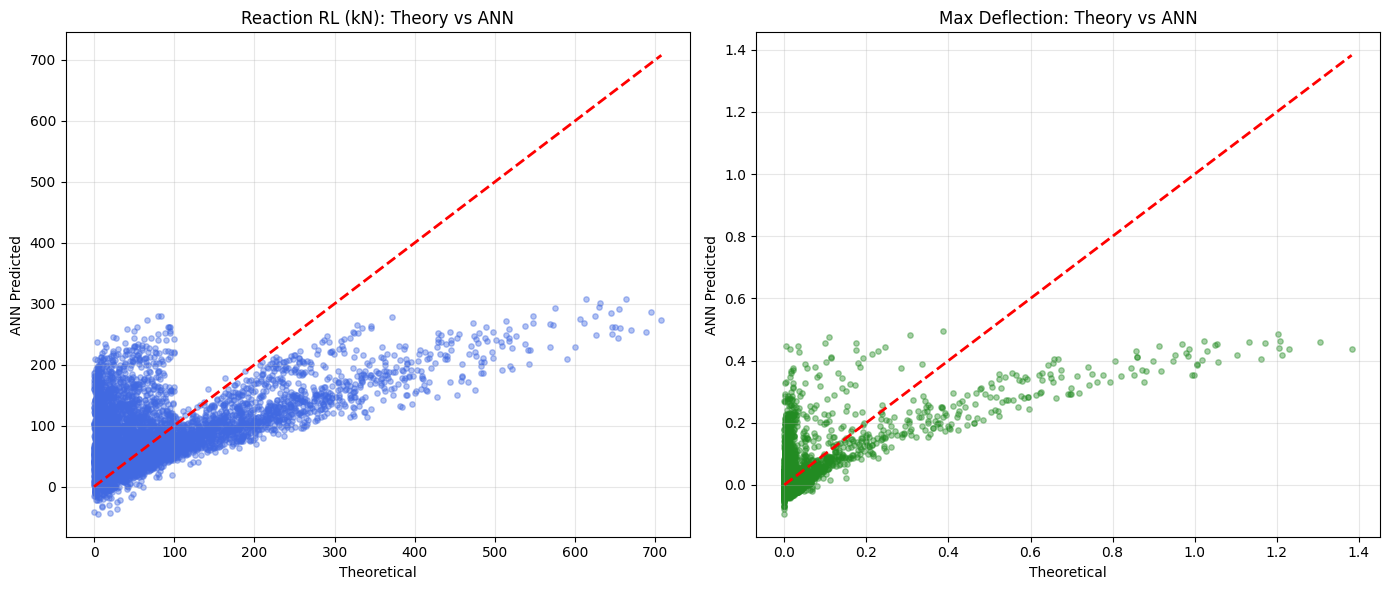

In [32]:
import matplotlib.pyplot as plt

# Predict using the scaled model
def predict_all(X):
    X_s = (X - X_mean) / X_std
    preds_s = model.forward(X_s)
    return (preds_s * y_std) + y_mean

predictions = predict_all(X_raw)

plt.figure(figsize=(14, 6))

# Plot 1: Reaction RL (Index 0)
plt.subplot(1, 2, 1)
plt.scatter(y_raw[:, 0], predictions[:, 0], alpha=0.4, color='royalblue', s=15)
# Add a 45-degree reference line
max_val = max(y_raw[:, 0].max(), predictions[:, 0].max())
plt.plot([0, max_val], [0, max_val], 'r--', lw=2)
plt.title('Reaction RL (kN): Theory vs ANN')
plt.xlabel('Theoretical')
plt.ylabel('ANN Predicted')
plt.grid(True, alpha=0.3)

# Plot 2: Max Deflection (Index 5)
plt.subplot(1, 2, 2)
plt.scatter(y_raw[:, 5], predictions[:, 5], alpha=0.4, color='forestgreen', s=15)
# Add a 45-degree reference line
max_val_d = max(y_raw[:, 5].max(), predictions[:, 5].max())
plt.plot([0, max_val_d], [0, max_val_d], 'r--', lw=2)
plt.title('Max Deflection: Theory vs ANN')
plt.xlabel('Theoretical')
plt.ylabel('ANN Predicted')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Data Generation
import numpy as np
import pandas as pd

# Constant Flexural Rigidity (Assumed)
EI = 200000 

def generate_full_dataset(n_samples=8000):
    data = []
    for _ in range(n_samples):
        ptype = np.random.randint(1, 9)
        L = np.random.uniform(3.0, 15.0)
        w = np.random.uniform(0.0, 50.0)
        P = np.random.uniform(0.0, 100.0)
        a = np.random.uniform(0.05 * L, 0.95 * L)
        b = L - a
        
        RL = Delta = 0

        # Formulas from PDF Problem Set-04
        if ptype == 1: # Cantilever, Point Load
            RL = P; Delta = (P * a**2 * (3*L - a)) / (6 * EI)
        elif ptype == 2: # Cantilever, UDL
            RL = w * L; Delta = (w * L**4) / (8 * EI)
        elif ptype == 3: # Simply Supported, Point Load
            RL = P * (L - a) / L; Delta = (P * a**2 * b**2) / (3 * EI * L)
        elif ptype == 4: # Simply Supported, UDL
            RL = (w * L) / 2; Delta = (5 * w * L**4) / (384 * EI)
        elif ptype == 5: # Propped Cantilever, Point Load
            RL = (P * (2*L**3 - 3*L*a**2 + a**3)) / (2 * L**3)
            Delta = (P * a**2 * b / (6*EI*(3*L - a))) * np.sqrt(3*L**2 - 4*L*a + a**2)
        elif ptype == 6: # Propped Cantilever, UDL
            RL = (5 * w * L) / 8; Delta = 0.00542 * (w * L**4) / EI
        elif ptype == 7: # Fixed End, Point Load
            RL = P * b**2 * (3*a + b) / (L**3); Delta = (P * a**3 * b**3) / (3 * EI * L**3)
        elif ptype == 8: # Fixed End, UDL
            RL = (w * L) / 2; Delta = (w * L**4) / (384 * EI)

        data.append([ptype, L, w, P, a, RL, abs(Delta)])

    return pd.DataFrame(data, columns=['Type', 'L', 'w', 'P', 'a', 'RL', 'DeltaMax'])

df = generate_full_dataset()

# Task 0: Data Statistics for validity 
print("--- Data Statistics ---")
print(df.describe())
df.to_csv('beam_dataset.csv', index=False)

In [ ]:
class BetterANN:
    def __init__(self, in_nodes, hid_nodes, out_nodes):
        np.random.seed(42)
        # He initialization for stability
        self.W1 = np.random.randn(in_nodes, hid_nodes) * np.sqrt(2/in_nodes)
        self.b1 = np.zeros((1, hid_nodes))
        self.W2 = np.random.randn(hid_nodes, out_nodes) * np.sqrt(2/hid_nodes)
        self.b2 = np.zeros((1, out_nodes))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

    def forward(self, X):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.sigmoid(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        return self.z2

    def train(self, X, y, lr=0.1, epochs=20000):
        for i in range(epochs):
            out = self.forward(X)
            err = out - y
            # Backpropagation
            dW2 = np.dot(self.a1.T, err) / X.shape[0]
            db2 = np.mean(err, axis=0)
            da1 = np.dot(err, self.W2.T) * (self.a1 * (1 - self.a1))
            dW1 = np.dot(X.T, da1) / X.shape[0]
            db1 = np.mean(da1, axis=0)
            # Weights Update
            self.W1 -= lr * dW1; self.b1 -= lr * db1
            self.W2 -= lr * dW2; self.b2 -= lr * db2
            if i % 2000 == 0:
                print(f"Epoch {i}, MSE Loss: {np.mean(np.square(err)):.6f}")

# Data Scaling
X_raw = df[['Type', 'L', 'w', 'P', 'a']].values
y_raw = df[['RL', 'DeltaMax']].values
X_mean, X_std = X_raw.mean(axis=0), X_raw.std(axis=0)
y_mean, y_std = y_raw.mean(axis=0), y_raw.std(axis=0)

X_scaled = (X_raw - X_mean) / X_std
y_scaled = (y_raw - y_mean) / y_std

# Train the model [cite: 4]
model = BetterANN(5, 64, 2)
model.train(X_scaled, y_scaled)